## HHL for Solving $A\vec{x}=\vec{b}$

This tutorial demonstrates an implementation of the HHL algorithm for a specific matrix. The Hamiltonian evolution is implemented by an "exact" operation, explicitly evaluating $e^{iA}$.

In [2]:
import numpy as np
import scipy

a_matrix = np.array(
    [
        [
            1.35130674e-01,
            -9.16087646e-02,
            -1.14652691e-02,
            -4.48607463e-02,
            -2.63467671e-02,
            -3.28138342e-02,
            2.99478858e-02,
            3.39541184e-02,
        ],
        [
            -9.16087646e-02,
            1.14855443e-01,
            1.95888296e-02,
            1.70687117e-02,
            4.36270565e-02,
            -8.52938635e-03,
            -1.50158078e-02,
            -7.23474326e-02,
        ],
        [
            -1.14652691e-02,
            1.95888296e-02,
            7.26847295e-02,
            -1.46375212e-04,
            -6.75909027e-02,
            -4.19539715e-02,
            4.27546953e-02,
            -1.09433808e-02,
        ],
        [
            -4.48607463e-02,
            1.70687117e-02,
            -1.46375212e-04,
            4.33257830e-02,
            2.79133772e-02,
            2.70712908e-02,
            -4.74604498e-02,
            -4.93775172e-03,
        ],
        [
            -2.63467671e-02,
            4.36270565e-02,
            -6.75909027e-02,
            2.79133772e-02,
            2.09737496e-01,
            7.91800534e-02,
            -1.76572887e-01,
            -4.96703677e-02,
        ],
        [
            -3.28138342e-02,
            -8.52938635e-03,
            -4.19539715e-02,
            2.70712908e-02,
            7.91800534e-02,
            1.20865829e-01,
            -1.23077162e-01,
            2.06192769e-02,
        ],
        [
            2.99478858e-02,
            -1.50158078e-02,
            4.27546953e-02,
            -4.74604498e-02,
            -1.76572887e-01,
            -1.23077162e-01,
            2.23903404e-01,
            1.07199035e-02,
        ],
        [
            3.39541184e-02,
            -7.23474326e-02,
            -1.09433808e-02,
            -4.93775172e-03,
            -4.96703677e-02,
            2.06192769e-02,
            1.07199035e-02,
            7.55903904e-02,
        ],
    ]
)

b_vector = np.array(
    [
        -0.00885448,
        -0.17725898,
        -0.15441119,
        0.17760157,
        0.41428775,
        0.44735303,
        -0.71137715,
        0.1878808,
    ]
)


sol_classical = np.linalg.solve(a_matrix, b_vector)  # classical solution

# number of qubits for the unitary
num_qubits = int(np.log2(len(b_vector)))
# exact unitary
my_unitary = scipy.linalg.expm(1j * 2 * np.pi * a_matrix)

In [3]:
# transpilation_options = {"classiq": "custom", "qiskit": 3} #uncomment this for deeper comparison
transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

## 1. HHL with Classiq

An HHL solver is tested for different precisions of the QPE size. The following function gets precision and returns the characteristics of the quantum program, as well as the overlap between the classical and the quantum solver.

In [4]:
from classiq import GeneratedCircuit, Model, execute, set_preferences, synthesize
from classiq.builtin_functions import (
    AmplitudeLoading,
    PhaseEstimation,
    StatePreparation,
    UnitaryGate,
)
from classiq.builtin_functions.amplitude_loading import AmplitudeLoadingImplementation
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.model import CustomHardwareSettings, Preferences
from classiq.synthesis import set_execution_preferences


def get_classiq_hhl_results(precision):
    """
    This function models, synthesizes, executes an HHL example and returns the depth, cx-counts and fidelity
    """

    # SP params
    b_normalized = tuple(b_vector)
    sp_upper = 0.00  # precision of the State Preparation
    sp = StatePreparation(
        amplitudes=b_normalized, error_metric={"L2": {"upper_bound": sp_upper}}
    )
    # number of qubits for the unitary
    num_qubits = int(np.log2(len(b_vector)))

    # QPE params
    exp_params = UnitaryGate(data=my_unitary.tolist())
    qpe = PhaseEstimation(size=precision, unitary_params=exp_params)

    # AL params
    expression = f"{1 / 2**precision}/(x)"  # for qpe register of size m, this is the minimal value which can be encoded
    al_params = AmplitudeLoading(
        size=precision,
        expression=expression,
        implementation=AmplitudeLoadingImplementation.GRAYCODE,
    )

    # Model
    model_hhl = Model()
    sp_out = model_hhl.StatePreparation(params=sp)
    qpe_out = model_hhl.PhaseEstimation(params=qpe, in_wires={"TARGET": sp_out["OUT"]})
    al_out = model_hhl.AmplitudeLoading(
        params=al_params,
        in_wires={"AMPLITUDE": qpe_out["PHASE_ESTIMATION"]},
    )
    i_qpe_out = model_hhl.PhaseEstimation(
        params=qpe,
        is_inverse=True,
        release_by_inverse=True,
        in_wires={
            "PHASE_ESTIMATION": al_out["AMPLITUDE"],
            "TARGET": qpe_out["TARGET"],
        },
    )
    model_hhl.sample()

    model_hhl.set_outputs({"target": al_out["TARGET"], "solution": i_qpe_out["TARGET"]})
    preferences = Preferences(
        custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
        transpilation_option=transpilation_options["classiq"],
    )
    backend_preferences = ClassiqBackendPreferences(
        backend_name="aer_simulator_statevector"
    )

    qmod_hhl = model_hhl.get_model()
    qmod_hhl = set_preferences(qmod_hhl, preferences)
    qmod_hhl = set_execution_preferences(
        qmod_hhl,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )

    # Synthesize
    qprog_hhl = synthesize(qmod_hhl)
    circuit_hhl = GeneratedCircuit.from_qprog(qprog_hhl)
    total_q = circuit_hhl.data.width  # total number of qubits of the whole circuit
    depth = circuit_hhl.transpiled_circuit.depth
    cx_counts = circuit_hhl.transpiled_circuit.count_ops["cx"]

    # Execute
    results = execute(qprog_hhl).result()
    res_hhl = results[0].value

    # Post-process

    target_pos = res_hhl.physical_qubits_map["target"][0]  # position of control qubit
    sol_pos = list(res_hhl.physical_qubits_map["solution"])  # position of solution
    phase_pos = [
        total_q - k - 1 for k in range(total_q) if k not in sol_pos + [target_pos]
    ]  # finds the position of the “phase” register, and flips for endianness as we will use the indices to read directly from the string
    qsol = [
        np.round(parsed_state.amplitude / (1 / 2**precision), 5)
        for solution in range(2**num_qubits)
        for parsed_state in res_hhl.parsed_state_vector
        if parsed_state["target"] == 1.0
        and parsed_state["solution"] == solution
        and [parsed_state.bitstring[k] for k in phase_pos]
        == ["0"]
        * precision  # this takes the entries where the “phase” register is at state zero
    ]

    fidelity = (
        np.abs(
            np.dot(
                sol_classical / np.linalg.norm(sol_classical),
                qsol / np.linalg.norm(qsol),
            )
        )
        ** 2
    )

    return total_q, depth, cx_counts, fidelity

In [5]:
classiq_widths = []
classiq_depths = []
classiq_cx_counts = []
classiq_fidelities = []
for per in range(2, 9):
    total_q, depth, cx_counts, fidelity = get_classiq_hhl_results(per)
    classiq_widths.append(total_q)
    classiq_depths.append(depth)
    classiq_cx_counts.append(cx_counts)
    classiq_fidelities.append(fidelity)

In [6]:
print("classiq overlap:", classiq_fidelities)
print("classiq depth:", classiq_depths)

classiq overlap: [0.3158031076949432, 0.4359945717049456, 0.5586001907051372, 0.6824244093393425, 0.8061698313600891, 0.9243747203835191, 0.9999999999926494]
classiq depth: [1141, 1671, 2210, 2763, 3350, 4000, 4777]


## 2. Comparing to Qiskit

Qiskit's HHL solver has been deprecated. For comparison, in an analogy to the Classiq model above, wire the four quantum blocks of the HHL algorithm in Qiskit.

In [7]:
from qiskit import BasicAer, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PhaseEstimation as PhaseEstimation_QISKIT
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal


def get_qiskit_hhl_results(precision):
    """
    This function creates an HHL circuit with qiskit, execute it and returns the depth, cx-counts and fidelity
    """

    vector_circuit = QuantumCircuit(num_qubits)
    vector_circuit.isometry(
        b_vector / np.linalg.norm(b_vector), list(range(num_qubits)), None
    )

    q = QuantumRegister(num_qubits, "q")
    unitary_qc = QuantumCircuit(q)
    unitary_qc.unitary(my_unitary.tolist(), q)
    qpe_qc = PhaseEstimation_QISKIT(precision, unitary_qc)
    reciprocal_circuit = ExactReciprocal(
        num_state_qubits=precision, scaling=1 / 2**precision
    )
    # Initialise the quantum registers
    qb = QuantumRegister(num_qubits)  # right hand side and solution
    ql = QuantumRegister(precision)  # eigenvalue evaluation qubits
    qf = QuantumRegister(1)  # flag qubits

    hhl_qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    hhl_qc.append(vector_circuit, qb[:])
    # QPE
    hhl_qc.append(qpe_qc, ql[:] + qb[:])
    # Conditioned rotation
    hhl_qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])

    # QPE inverse
    hhl_qc.append(qpe_qc.inverse(), ql[:] + qb[:])

    # transpile
    tqc = transpile(
        hhl_qc,
        basis_gates=["u3", "cx"],
        optimization_level=transpilation_options["qiskit"],
    )
    depth = tqc.depth()
    cx_counts = tqc.count_ops()["cx"]
    total_q = tqc.width()

    # execute
    backend = BasicAer.get_backend("statevector_simulator")
    job = backend.run(tqc)
    result = job.result()
    statevector = np.array(result.get_statevector(tqc, 5))

    # post_process
    all_entries = [np.binary_repr(k, total_q) for k in range(2**total_q)]
    sol_indices = [
        int(entry, 2)
        for entry in all_entries
        if entry[0] == "1" and entry[1 : precision + 1] == "0" * precision
    ]
    qsol = statevector[sol_indices] / (1 / 2**precision)

    sol_classical = np.linalg.solve(a_matrix, b_vector)
    fidelity = (
        np.abs(
            np.dot(
                sol_classical / np.linalg.norm(sol_classical),
                qsol / np.linalg.norm(qsol),
            )
        )
        ** 2
    )

    return total_q, depth, cx_counts, fidelity

In [12]:
qiskit_widths = []
qiskit_depths = []
qiskit_cx_counts = []
qiskit_fidelities = []

for per in range(2, 9):
    total_q, depth, cx_counts, fidelity = get_qiskit_hhl_results(per)
    qiskit_widths.append(total_q)
    qiskit_depths.append(depth)
    qiskit_cx_counts.append(cx_counts)
    qiskit_fidelities.append(fidelity)

In [9]:
print("qiskit overlap:", qiskit_fidelities)
print("qiskit depth:", qiskit_depths)

qiskit overlap: [0.31580151346948165, 0.4359875238048639, 0.5586021581341646, 0.6824176871922585, 0.8061686228192583, 0.9243809940973051, 0.9999998678594441]
qiskit depth: [2387, 5561, 11901, 24577, 49925, 100617, 201997]


## 3. Plotting the Data

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0.2, 0, '$\\mathdefault{0.2}$'),
  Text(0.30000000000000004, 0, '$\\mathdefault{0.3}$'),
  Text(0.4, 0, '$\\mathdefault{0.4}$'),
  Text(0.5, 0, '$\\mathdefault{0.5}$'),
  Text(0.6000000000000001, 0, '$\\mathdefault{0.6}$'),
  Text(0.7, 0, '$\\mathdefault{0.7}$'),
  Text(0.8, 0, '$\\mathdefault{0.8}$'),
  Text(0.9000000000000001, 0, '$\\mathdefault{0.9}$'),
  Text(1.0, 0, '$\\mathdefault{1.0}$'),
  Text(1.1, 0, '$\\mathdefault{1.1}$')])

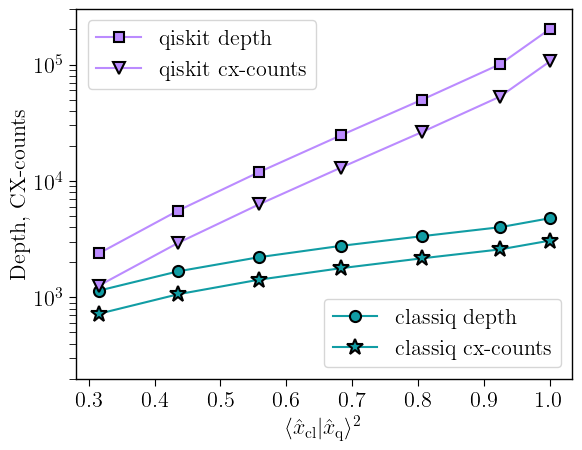

In [11]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
qiskit_color = "#bb8bff"
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5


(classiq1,) = plt.semilogy(
    classiq_fidelities,
    classiq_depths,
    "-o",
    label="classiq depth",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(classiq2,) = plt.semilogy(
    classiq_fidelities,
    classiq_cx_counts,
    "-*",
    label="classiq cx-counts",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=12,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(qiskit1,) = plt.semilogy(
    qiskit_fidelities,
    qiskit_depths,
    "-s",
    label="qiskit depth",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)
(qiskit2,) = plt.semilogy(
    qiskit_fidelities,
    qiskit_cx_counts,
    "-v",
    label="qiskit cx-counts",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)

first_legend = plt.legend(
    handles=[qiskit1, qiskit2],
    fontsize=16,
    loc="upper left",
)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[classiq1, classiq2], fontsize=16, loc="lower right")

# plt.ylim(0.2e3,2e5)
plt.ylim(0.2e3, 3e5)
plt.ylabel("Depth, CX-counts", fontsize=16)
plt.xlabel(r"$\langle\hat{x}_{\rm cl}|\hat{x}_{\rm q}\rangle^2$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)